In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/metadata.csv")

In [3]:
df

card_file_name     id  \
0          data/pictures/Base Set/Alakazam_(Base_Set_1)  1/102   
1         data/pictures/Base Set/Blastoise_(Base_Set_2)  2/102   
2           data/pictures/Base Set/Chansey_(Base_Set_3)  3/102   
3         data/pictures/Base Set/Charizard_(Base_Set_4)  4/102   
4          data/pictures/Base Set/Clefairy_(Base_Set_5)  5/102   
...                                                 ...    ...   
9937  data/pictures/Pokémon Rumble/Lucario_(Pok%C3%A...  12/16   
9938  data/pictures/Pokémon Rumble/Skuntank_(Pok%C3%...  13/16   
9939  data/pictures/Pokémon Rumble/Bastiodon_(Pok%C3...  14/16   
9940  data/pictures/Pokémon Rumble/Rattata_(Pok%C3%A...  15/16   
9941  data/pictures/Pokémon Rumble/Bibarel_(Pok%C3%A...  16/16   

                                                   link       name  \
0     https://bulbapedia.bulbagarden.net/wiki/Alakaz...   Alakazam   
1     https://bulbapedia.bulbagarden.net/wiki/Blasto...  Blastoise   
2     https://bulbapedia.bulbagarden.net/wiki/Chanse...    Chansey   
3     https://bulbapedia.bulbagarden.net/wiki/Chariz...  Charizard   
4     https://bulbapedia.bulbagarden.net/wiki/Clefai...   Clefairy   
...                                                 ...        ...   
9937  https://bulbapedia.bulbagarden.net/wiki/Lucari...    Lucario   
9938  https://bulbapedia.bulbagarden.net/wiki/Skunta...   Skuntank   
9939  https://bulbapedia.bulbagarden.net/wiki/Bastio...  Bastiodon   
9940  https://bulbapedia.bulbagarden.net/wiki/Rattat...    Rattata   
9941  https://bulbapedia.bulbagarden.net/wiki/Bibare...    Bibarel   

              rarity         setname       type  
0          Rare Holo        Base Set    Psychic  
1          Rare Holo        Base Set      Water  
2          Rare Holo        Base Set  Colorless  
3          Rare Holo        Base Set       Fire  
4          Rare Holo        Base Set  Colorless  
...              ...             ...        ...  
9937  Unknown rarity  Pokémon Rumble   Fighting  
9938  Unknown rarity  Pokémon Rumble   Darkness  
9939  Unknown rarity  Pokémon Rumble      Metal  
9940  Unknown rarity  Pokémon Rumble  Colorless  
9941  Unknown rarity  Pokémon Rumble  Colorless  

[9942 rows x 7 columns]

# Drop a couple of bad records

In [4]:
df = df[~df["card_file_name"].isin([
    "data/pictures/Mysterious Treasures/Honchkrow_(Mysterious_Treasures_10)",
    "data/pictures/Unified Minds/Umbreon_%26_Darkrai-GX_(Unified_Minds_125)", # missing on website
    "data/pictures/Base Set/Charizard_(Base_Set_4)", # special version of normal website
    "data/pictures/Stormfront/Charizard_(Stormfront_103)", # special version of normal website
])]

filter to Pokemon types

In [5]:
# df.type.value_counts()
filter_to_pokemon_types = False

if filter_to_pokemon_types:
    df = df[df["type"].isin([
        "Water",
        "Grass",
        "Colorless",
        "Psychic",
        "Fighting",
        "Fire",
        "Lightning",
        "Darkness",
        "Metal",
        "Dragon",
        "Fairy",
    ])]

# Create dataset

In [6]:
# Function to load and preprocess each image
def parse_image_file(filename, label = None):
    img = tf.io.read_file(filename)
    img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float32) / 255.0
    
#     if img.shape[0] < 50:
#         print(f"Error with image `{filename}`: shape found was small: {img.shape}")
    img = tf.image.resize_with_crop_or_pad(img, 260, 180)
    
    # Some images have an extra alpha channel. Remove that.
    img = img[:, :, :3]
    
    if label is None: return img
    else: return img, label

In [7]:
classnames, indices = np.unique(df["setname"].values, return_inverse=True)

y = keras.utils.to_categorical(
        indices
)

In [8]:
n_classes = y.shape[-1]
n_records = df.shape[0]

In [11]:
x = tf.constant(df["card_file_name"].values)

all_data = tf.data.Dataset.from_tensor_slices(
    (x, y)
).map(parse_image_file).shuffle(10000)

# Split dataset

In [12]:
train_frac = .7
batch_size = 50

train = all_data.take(int(train_frac * n_records)).batch(batch_size)
remaining_data = all_data.skip(int(train_frac * n_records))

validate = remaining_data.take(int(.5 * (1 - train_frac) * n_records)).batch(batch_size)
test = remaining_data.skip(int(.5 * (1 - train_frac) * n_records)).batch(batch_size)

# Model

In [33]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=30, kernel_size=5, strides=2),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(filters=30, kernel_size=5, strides=2),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=80, activation="relu"),
    keras.layers.Dense(units=80, activation="relu"),
    keras.layers.Dense(units=n_classes, activation="softmax"),
])

In [34]:
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.categorical_accuracy]
)

In [35]:
try:
    model.fit(train, validation_data=validate, epochs=22, shuffle=True)
finally:
    gc.collect()

Epoch 1/22
140/140 [==============================] - 52s 373ms/step - loss: 3.8165 - categorical_accuracy: 0.0794 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/22
140/140 [==============================] - 51s 364ms/step - loss: 2.5635 - categorical_accuracy: 0.2415 - val_loss: 2.6294 - val_categorical_accuracy: 0.2282
Epoch 3/22
140/140 [==============================] - 51s 364ms/step - loss: 2.1273 - categorical_accuracy: 0.3426 - val_loss: 2.1159 - val_categorical_accuracy: 0.3591
Epoch 4/22
140/140 [==============================] - 51s 364ms/step - loss: 1.8145 - categorical_accuracy: 0.4376 - val_loss: 1.6910 - val_categorical_accuracy: 0.4725
Epoch 5/22
140/140 [==============================] - 51s 364ms/step - loss: 1.5509 - categorical_accuracy: 0.5283 - val_loss: 1.6132 - val_categorical_accuracy: 0.5087
Epoch 6/22
140/140 [==============================] - 51s 364ms/step - loss: 1.3427 - categorical_accuracy: 0.5914 - val_loss: 1.8604 - val_categor

In [36]:
gc.collect()

20

# Test a couple of records

In [37]:
def label_converter(label):
    return tf.math.argmax(label, axis=-1)

In [38]:
def plot_and_predict(img):
    assert img.shape[0] == 1, "Please only provide a single image at a time"
    
    prediction = model.predict(img)
    class_index = label_converter(prediction)
    class_name = classnames[class_index[0]]
    
    plt.imshow(img[0])
    plt.title(class_name)
    

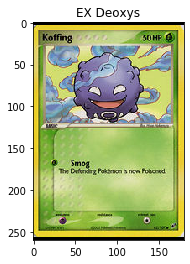

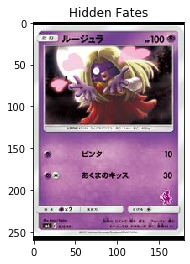

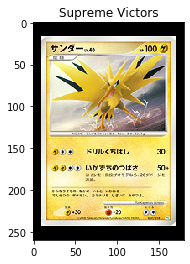

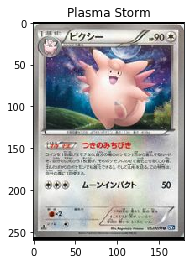

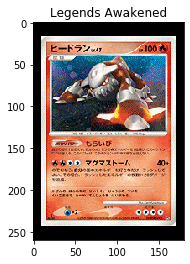

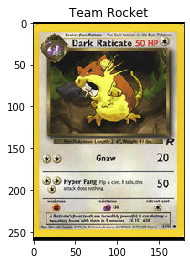

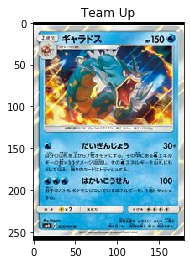

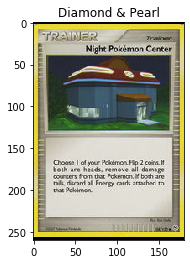

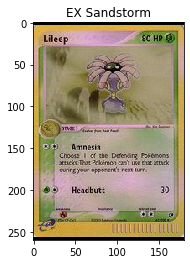

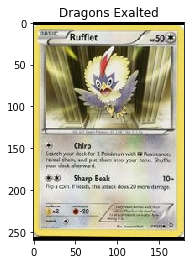

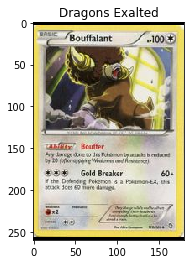

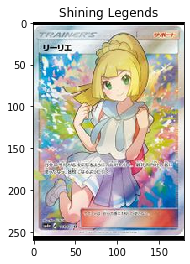

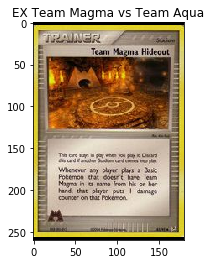

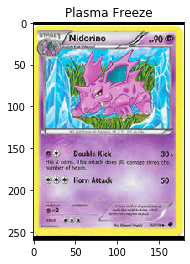

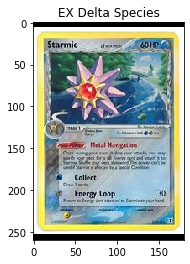

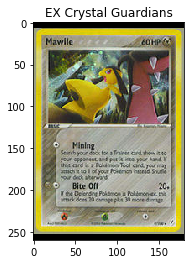

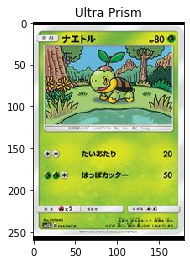

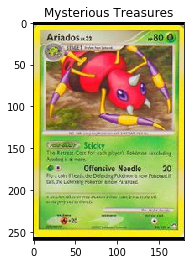

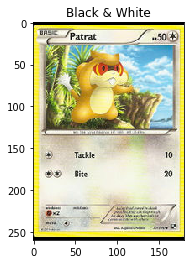

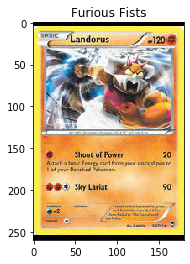

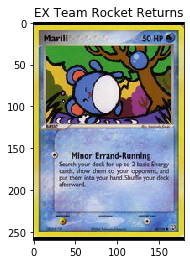

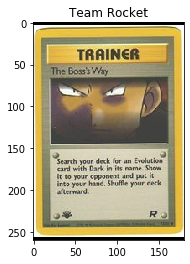

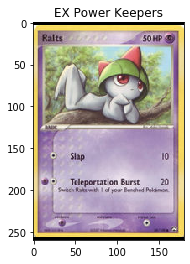

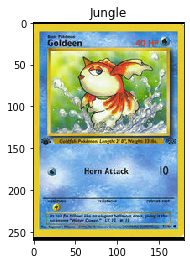

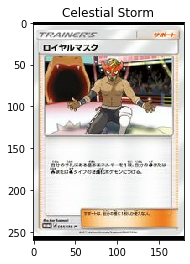

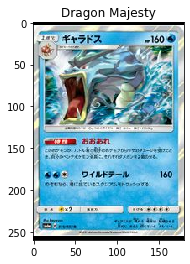

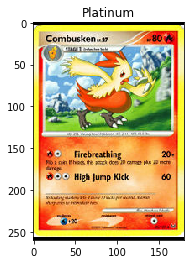

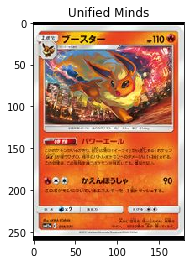

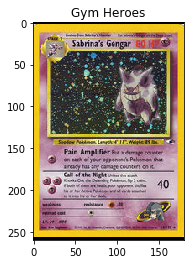

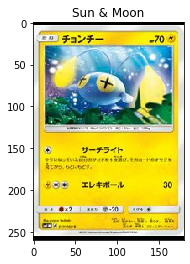

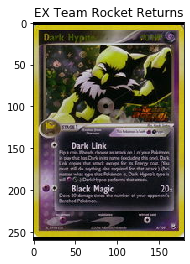

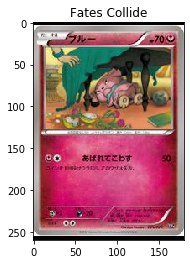

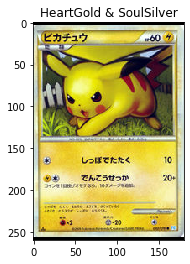

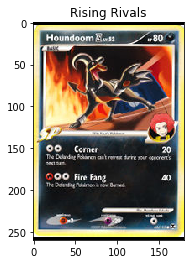

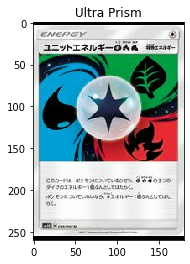

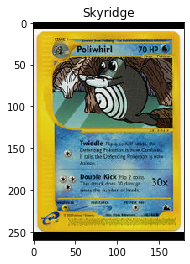

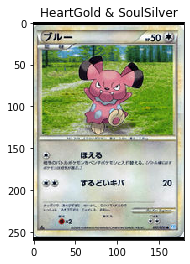

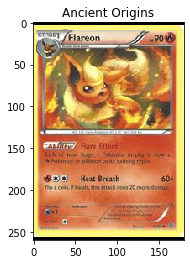

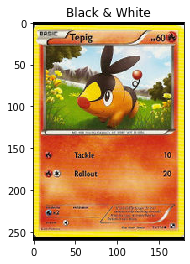

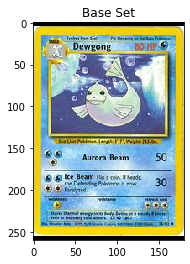

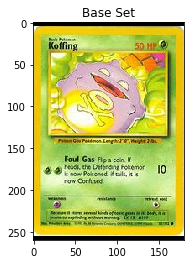

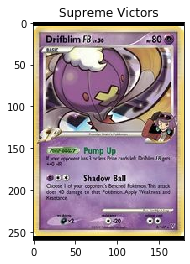

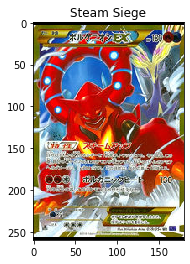

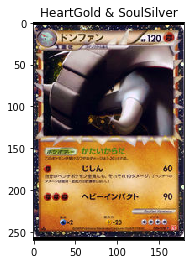

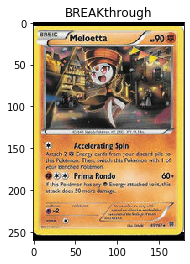

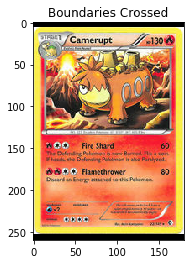

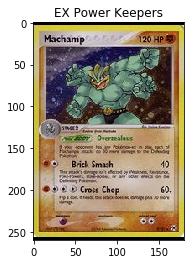

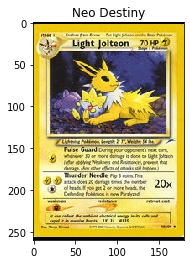

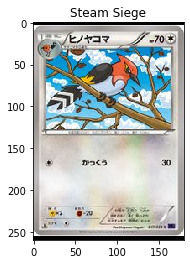

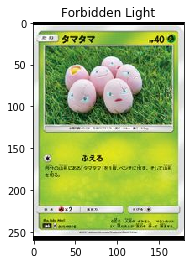

47312

In [39]:
for vis_x, _ in train.take(1):
    for i in range(vis_x.shape[0]):
        plot_and_predict(vis_x[i:i+1])
        plt.show()
gc.collect()